In [2]:
import os
import gc
import re
import json
import pickle
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd

from typing import Union

import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

from scipy.stats import linregress

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import lightgbm as lgb

In [3]:
VERSION = 'v00000'

In [4]:
train = pd.read_pickle('/Users/rui/Documents/repositories/m5_forecasting_accuracy/v01000/features/add_price_train.pkl')

In [5]:
print(train.shape)
train.tail()

(46881677, 74)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,sales_rolling_MIN_t60,sales_rolling_MAX_t7,sales_rolling_MAX_t30,sales_rolling_MAX_t60,sales_rolling_SKEW_t30,sales_rolling_KURT_t30,sell_price_lag_t28,sell_price_price_change_t365,sell_price_rolling_price_std_t7,sell_price_rolling_price_std_t30
46881672,FOODS_3_823_WI_3_validation,1432,2,0,9,2,d_1941,0,2016-05-22,11617,...,0.0,1.0,2.0,2.0,2.757812,6.730469,2.980469,0.0,0.000000e+00,0.000000
46881673,FOODS_3_824_WI_3_validation,1433,2,0,9,2,d_1941,0,2016-05-22,11617,...,0.0,1.0,2.0,2.0,1.621094,1.950195,2.480469,0.0,5.960464e-08,0.206665
46881674,FOODS_3_825_WI_3_validation,1434,2,0,9,2,d_1941,0,2016-05-22,11617,...,0.0,2.0,4.0,4.0,1.485352,1.986328,3.980469,0.0,0.000000e+00,0.000000
46881675,FOODS_3_826_WI_3_validation,1435,2,0,9,2,d_1941,0,2016-05-22,11617,...,0.0,3.0,4.0,4.0,0.962891,-0.021317,1.280273,0.0,0.000000e+00,0.000000
46881676,FOODS_3_827_WI_3_validation,1436,2,0,9,2,d_1941,0,2016-05-22,11617,...,0.0,0.0,7.0,7.0,1.680664,2.517578,1.000000,0.0,0.000000e+00,0.000000


In [6]:
def split_train_eval_submit(df, pred_interval=28):
    latest_date = df['date'].max()
    submit_date = latest_date - datetime.timedelta(days=pred_interval)
    submit_mask = (df["date"] > submit_date)

    eval_date = latest_date - datetime.timedelta(days=pred_interval * 2)
    eval_mask = ((df["date"] > eval_date) & (df["date"] <= submit_date))

    train_mask = ((~eval_mask) & (~submit_mask))
    return df[train_mask], df[eval_mask], df[submit_mask]

In [7]:
train_data, eval_data, submit_data = split_train_eval_submit(train)

In [8]:
print('train_data dataframe:', train_data.shape)
display(train_data.head())

print('eval_data dataframe:', eval_data.shape)
display(eval_data.head())

print('submit_data dataframe:', submit_data.shape)
display(submit_data.head())

train_data dataframe: (45174237, 74)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,sales_rolling_MIN_t60,sales_rolling_MAX_t7,sales_rolling_MAX_t30,sales_rolling_MAX_t60,sales_rolling_SKEW_t30,sales_rolling_KURT_t30,sell_price_lag_t28,sell_price_price_change_t365,sell_price_rolling_price_std_t7,sell_price_rolling_price_std_t30
0,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,d_1,12,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HOBBIES_1_009_CA_1_validation,1445,3,1,0,0,d_1,2,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HOBBIES_1_010_CA_1_validation,1446,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HOBBIES_1_012_CA_1_validation,1448,3,1,0,0,d_1,0,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOBBIES_1_015_CA_1_validation,1451,3,1,0,0,d_1,4,2011-01-29,11101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


eval_data dataframe: (853720, 74)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,sales_rolling_MIN_t60,sales_rolling_MAX_t7,sales_rolling_MAX_t30,sales_rolling_MAX_t60,sales_rolling_SKEW_t30,sales_rolling_KURT_t30,sell_price_lag_t28,sell_price_price_change_t365,sell_price_rolling_price_std_t7,sell_price_rolling_price_std_t30
45174237,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1886,1,2016-03-28,11609,...,0.0,4.0,4.0,5.0,1.423828,1.454102,8.257812,0.0,5.960464e-08,0.000000e+00
45174238,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1886,1,2016-03-28,11609,...,0.0,1.0,1.0,1.0,1.884766,1.657227,3.970703,0.0,0.000000e+00,0.000000e+00
45174239,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1886,0,2016-03-28,11609,...,0.0,0.0,1.0,1.0,0.919434,-1.242188,2.970703,0.0,0.000000e+00,0.000000e+00
45174240,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1886,0,2016-03-28,11609,...,0.0,6.0,6.0,8.0,0.679199,-0.583984,4.640625,0.0,0.000000e+00,5.960464e-08
45174241,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1886,1,2016-03-28,11609,...,0.0,3.0,5.0,5.0,1.329102,1.589844,2.880859,0.0,0.000000e+00,0.000000e+00


submit_data dataframe: (853720, 74)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,sales_rolling_MIN_t60,sales_rolling_MAX_t7,sales_rolling_MAX_t30,sales_rolling_MAX_t60,sales_rolling_SKEW_t30,sales_rolling_KURT_t30,sell_price_lag_t28,sell_price_price_change_t365,sell_price_rolling_price_std_t7,sell_price_rolling_price_std_t30
46027957,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1914,0,2016-04-25,11613,...,0.0,2.0,3.0,4.0,0.763184,0.018387,8.257812,-0.015137,5.960464e-08,0.000000e+00
46027958,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1914,0,2016-04-25,11613,...,0.0,1.0,1.0,1.0,0.745117,-1.553711,3.970703,0.000000,0.000000e+00,0.000000e+00
46027959,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1914,0,2016-04-25,11613,...,0.0,1.0,6.0,6.0,3.904297,17.734375,2.970703,0.000000,0.000000e+00,0.000000e+00
46027960,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1914,0,2016-04-25,11613,...,0.0,6.0,6.0,6.0,0.791016,-0.692871,4.640625,0.000000,0.000000e+00,5.960464e-08
46027961,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1914,0,2016-04-25,11613,...,0.0,3.0,3.0,5.0,0.541992,-0.524414,2.880859,0.000000,0.000000e+00,0.000000e+00




---




In [28]:
def rmsle(preds, actual, weight=None):
    return np.sqrt(mean_squared_log_error(actual, preds, sample_weight=weight))


def lgbm_rmsle(preds, data):
    weight = None  # data.get_weight()
    actual = data.get_label()
    metric_name = 'RMSLE' if weight is None else 'WRMSLE'
    return metric_name, rmsle(preds, actual), False

In [39]:
class LGBM_Model():
    def __init__(self, X, y, cv_param, model_param, train_param, groups=None):
        self.cv = self.set_cv(cv_param)
        self.models = self.fit(X, y, model_param, train_param, groups)
    
    def set_cv(self, cv_param):
        cv = TimeSeriesSplit(n_splits=cv_param['n_splits'], max_train_size=cv_param['max_train_size'])
        return cv
    
    def fit(self, X, y, model_param, train_param, groups):
        models = []
        for n_fold, (train_idx, valid_idx) in enumerate(self.cv.split(X)):
            print(f"\n{n_fold + 1} of {self.cv.get_n_splits()} Fold:\n")
            train_X, train_y = X.iloc[train_idx], y.iloc[train_idx]
            valid_X, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]

            print('Train DataFrame Size:', train_X.shape)
            print('Valid DataFrame Size:', valid_X.shape)
            train_dataset = lgb.Dataset(train_X, label=train_y)
            valid_dataset = lgb.Dataset(valid_X, label=valid_y, reference=train_dataset)
            model = lgb.train(
                model_param,
                train_dataset,
                valid_sets=[train_dataset, valid_dataset],
                valid_names=["train", "valid"],
                **train_param
            )
            models.append(model)
            del train_X, valid_X, train_y, valid_y; gc.collect()
        return models
    
    def get_models(self):
        return self.models
       
    def predict(self, data):
        models = self.get_models()
        return [m.predict(data.values, num_iteration=m.best_iteration) for m in models]
    
    def save_importance(self, filepath, max_num_features=50, figsize=(15, 20), plot=False):
        models = self.get_models()
        # Define Feature Importance DataFrame.
        imp_df = pd.DataFrame(
            [m.feature_importance() for m in models],
            columns=models[0].feature_name()
        ).T
        imp_df['AVG_Importance'] = imp_df.iloc[:, :len(models)].mean(axis=1)
        imp_df['STD_Importance'] = imp_df.iloc[:, :len(models)].std(axis=1)
        imp_df.sort_values(by='AVG_Importance', inplace=True)
        # Plot Importance DataFrame.
        plt.figure(figsize=figsize)
        imp_df[-max_num_features:].plot(
            kind='barh', title='Feature importance', figsize=figsize,
            y='AVG_Importance', xerr='STD_Importance', align="center"
        )
        if plot:
            plt.show()
        plt.savefig(filepath)
        plt.close('all')

In [47]:
target = 'sales'
cols_to_drop = ['id', 'wm_yr_wk', 'd', 'date'] + [target]
features = train.columns.tolist()
features = [f for f in features if f not in cols_to_drop]

cv_param = {
    "n_splits": 3,
    "max_train_size": None
}

model_param = {
    "boosting_type": "gbdt",
    "metric": "mape",
    "objective": "regression",
    "n_estimators": 10, # 100000,
    "seed": 11,
    "learning_rate": 0.3,
    'max_depth': 5,
    'num_leaves': 32,
    'min_data_in_leaf': 50,
    "bagging_fraction": 0.8,
    "bagging_freq": 10,
    "feature_fraction": 0.8,
    "verbosity": -1
}

train_param = {
    "num_boost_round": 100000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

In [48]:
lgbm_model = LGBM_Model(train, train[features], train[target], cv_param, model_param, train_param)


1 of 3 Fold:

Train DataFrame Size: (11720420, 69)
Valid DataFrame Size: (11720419, 69)


/Users/rui/Documents/repositories/m5_forecasting_accuracy/.venv/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10]	train's mape: 0.715196	valid's mape: 0.683947

2 of 3 Fold:

Train DataFrame Size: (23440839, 69)
Valid DataFrame Size: (11720419, 69)
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10]	train's mape: 0.690472	valid's mape: 0.648055

3 of 3 Fold:

Train DataFrame Size: (35161258, 69)
Valid DataFrame Size: (11720419, 69)
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[10]	train's mape: 0.666645	valid's mape: 0.679118


<Figure size 1080x1440 with 0 Axes>

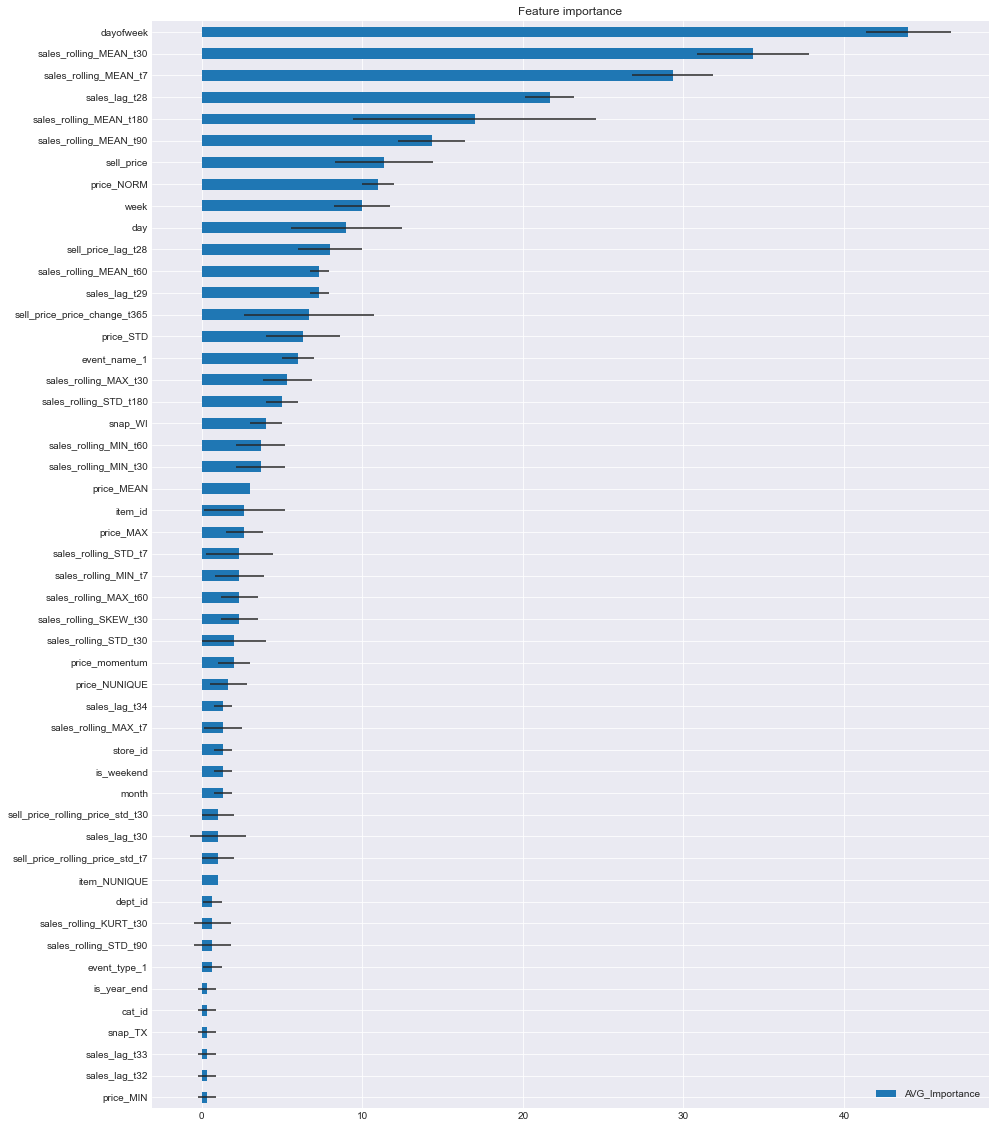

In [49]:
lgbm_model.save_importance(filepath=f'result/importance/{VERSION}.png', plot=True)

In [52]:
print('\n--- Evaluation ---\n')
preds = np.mean(lgbm_model.predict(eval_data[features]), axis=0)
metric_scores = {}
metric_scores['RMSE'] = mean_squared_error(eval_data['sales'].values, preds, squared=False)
print(metric_scores)


--- Evaluation ---

{'RMSE': 0.5369683133366461}


In [46]:
print('RMSE')
print('\n--- Evaluation ---\n')
preds = np.mean(lgbm_model.predict(eval_data[features]), axis=0)
metric_scores = {}
metric_scores['RMSE'] = mean_squared_error(eval_data['sales'].values, preds, squared=False)
print(metric_scores)

RMSE

--- Evaluation ---

{'RMSE': 2.1806464806246706}
